In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchaudio
import torchaudio.models as models
import torchaudio.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
import glob
import librosa
import librosa.display
import soundfile as sf
from scipy.interpolate import interp1d
import IPython.display as ipd
import ast
import time
import sys
from nnutils import reshape_mel_spec, RainforestNet

In [2]:
# Load meta.csv to save metadata for training session
try:
    meta = pd.read_csv('models/meta.csv')
except:
    meta = pd.DataFrame()


In [11]:
# Hyper parameters
class Params():
    EPOCHS = 10
    TRAIN_BATCH_SIZE = 4
    N_MELS = 256
    MEL_SPEC_MAXLEN = 800
    LR = 0.0001
    def __to_dict__(self):
        return {key:value for key, value in Params.__dict__.items() if not key.startswith('__') and not callable(key)}
                      
params = Params()

In [4]:
# CUDA
is_cuda = True and torch.cuda.is_available()
cpu = torch.device('cpu')
gpu = torch.device('cuda')
device = gpu if is_cuda else cpu

print ('cuda: ', is_cuda)

torch.cuda.empty_cache()

cuda:  True


In [5]:
class MelSpecDataset(Dataset):
    def __init__(self, source_file):
        self.source = pd.read_csv(source_file)
        
        mel_specs = []
        wvs = []
        sample_rate = int(self.source.iloc[0].sample_rate)
        mel_trans = transforms.MelSpectrogram(sample_rate=sample_rate, n_mels=params.N_MELS).to(device)
        
        for idx in tqdm(range(len(self.source))):
            ex = self.source.iloc[idx]
            waveform = ex.waveform

            if isinstance(waveform, str): 
                wv = ','.join(ex.waveform.replace('[ ', '[').split())
                wv = np.array(ast.literal_eval(wv))
                waveform = torch.from_numpy(wv).view(1, -1).to(dtype=torch.float32)

                wvs.append(waveform)

            sample_rate = int(ex.sample_rate)
            
            waveform = waveform.to(device).view(1, 1, -1)
            
            mel_spec = mel_trans(waveform)
            mel_spec = reshape_mel_spec(mel_spec[0], params.MEL_SPEC_MAXLEN).to(cpu)
                        
            mel_specs.append(mel_spec)

        if 'mel_spec' in self.source:
            self.source = self.source.assign(mel_spec=mel_specs)
        else:
            self.source.insert(4, "mel_spec", mel_specs, True)
            
        # drop waveform data for now to save memory
        self.source = self.source.drop(columns=['waveform'])
        
        # uncomment to visualize waveform
        #if len(wvs) > 0:
        #    self.source = self.source.assign(waveform=wvs)
    def get_waveform(self, idx):
        ex = self.source.iloc[idx]
        return (ex.waveform, ex.sample_rate)
    def __getitem__(self, idx):
        ex = self.source.iloc[idx]
        return (ex.mel_spec, int(ex.species_id))
    def __len__(self):
        return len(self.source)

In [6]:
trainset = MelSpecDataset('train_classified-all.csv')
trainloader = torch.utils.data.DataLoader(trainset, batch_size=params.TRAIN_BATCH_SIZE,shuffle=True)

In [7]:
model = RainforestNet().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=params.LR)

In [8]:
print (len(trainset))

1216


In [12]:
start_time = time.time()
losses = []
losses_detail = []

for epoch in range(params.EPOCHS):
    running_loss = 0.0
    t = tqdm(trainloader, desc="epoch {}/{}, running loss: {}".format(epoch+1, params.EPOCHS, 0.0))
    for i, data in enumerate(t):
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
                        
        optimizer.zero_grad()
                
        output = model(inputs)
        loss = criterion(output, labels)
        
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        losses_detail.append(loss.item())
        if i % 50 == 49:    # print every 50 mini-batches
            #print('[%d %5d] loss: %.3f' % (epoch+1, i+1, running_loss / 50))
            
            losses.append(running_loss/50)
            t.set_description("epoch {}/{}, running_loss: {:.2f}".format(epoch+1, params.EPOCHS, running_loss/50))
            t.refresh()
            
            running_loss = 0.0
            
end_time = time.time()
print ('\n-------- DONE --------')
print ('start time: {}'.format(start_time))
print ('end time: {}\n'.format(end_time))

duration = end_time-start_time
print ('training duration: {}'.format(duration))

model_path = 'models/rainforest{}.pt'.format(end_time)
torch.save(model.state_dict(), model_path)

mdata = params.__to_dict__()
mdata.update({
    'start_time': start_time,
    'end_time': end_time,
    'train_duration': duration,
    'model_path': model_path,
})
meta = meta.append(mdata, ignore_index=True)
meta.to_csv("models/meta.csv", index=False, float_format='%.5f')



-------- DONE --------
start time: 1608610039.2968016
end time: 1608610558.9047544

training duration: 519.6079528331757


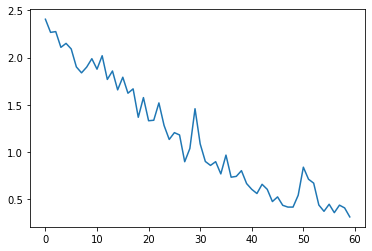

In [13]:
fig, ax = plt.subplots()
ax.plot(losses)